#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [1]:
#!pip install pybna # if you need to install please remove comment out

In [2]:
# if you need to install please remove comment out
#!pip install -r requirements.txt
#!pip install SQLAlchemy
#!pip install momepy

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pybna\conf.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [4]:

from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import Point
from functools import reduce
#import matplotlib.pyplot as plt  ## not needed
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import csv
from time import time
import time
from geopandas import GeoSeries, GeoDataFrame

In [ ]:
#conda install arcpy=3.0 -c esri

In [ ]:
#import arcpy
#from arcpy import env

In [ ]:
%%time
# Import Configuration file
i = pybna.Importer(config="config.yaml")
# Import Study Area boundary shape file
i.import_boundary('geo_export_b69ec18e-6a40-4637-94f6-1f3aafe63144.shp', overwrite=True)
# Mention the State fips, for California it is 6
i.import_census_blocks(fips=6, overwrite=True)
i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

In [ ]:
%%time
i.import_osm_network(overwrite=True)

In [ ]:
%%time
#Increase the timeout in your importer file if your computer is weak to avoid error
#i.import_osm_destinations(overwrite=True)


In [ ]:
%%time
# stress
s = pybna.Stress(config='config.yaml')
s.segment_stress()
s.crossing_stress()

In [ ]:
#%%time
# connectivity
#bna = pybna.pyBNA(config='config.yaml')
#bna.calculate_connectivity()

In [ ]:
#%%time
# scores
#bna.score("myschema.my_scores_table")
#bna.aggregate("myschema.my_aggregate_score_table")

In [5]:
# Read the LTS shape file
lts=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/neighborhood_ways.shp")
lts = lts.rename(columns={'OSMID':'osmid'})
lts=lts.rename({'INTERSECTI':'u', 'INTERSE_01':'v'}, axis='columns')
lts['length']=lts.length
lts.head()

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,111276,{31439803},tertiary,None,ft,419038,419030,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,3.0,None,"LINESTRING (91536.677 -976.326, 91560.948 -973...",24.398252
1,162454,{93291777},tertiary,None,ft,364379,364375,NaN,NaN,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (108350.827 -24102.437, 108425.349 ...",75.902661
2,165633,{184388728},primary,None,ft,329656,329657,NaN,35.0,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (94730.324 -23220.754, 94768.157 -2...",37.835842
3,888344,{53726448},tertiary,None,ft,76716,76717,NaN,NaN,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (65934.473 27367.107, 65935.819 273...",1.539394
4,923150,{655711604},residential,None,ft,129104,129102,NaN,NaN,None,...,None,?,?,1.0,NaN,NaN,NaN,None,"LINESTRING (41921.847 57781.540, 41918.170 577...",3.697954


# Lets calculate the slope for each link

In [6]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

In [7]:
# Open the raster image
barea_slope = rasterio.open('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/Slope/Slope/cslope11.img')
print(barea_slope.crs)
#rioplot.show(barea_slope)

EPSG:4269


In [8]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -104, 'mean': -3.891794414661842, 'max': 1784}


In [9]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TWLTL_CROS,FT_PARK,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length
0,111276,{31439803},tertiary,None,ft,419038,419030,NaN,NaN,None,...,None,?,?,4.0,NaN,NaN,3.0,None,"LINESTRING (-121.95749 37.52394, -121.95722 37...",24.398252
1,162454,{93291777},tertiary,None,ft,364379,364375,NaN,NaN,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (-121.76918 37.31464, -121.76834 37...",75.902661
2,165633,{184388728},primary,None,ft,329656,329657,NaN,35.0,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (-121.92277 37.32337, -121.92235 37...",37.835842
3,888344,{53726448},tertiary,None,ft,76716,76717,NaN,NaN,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (-122.24642 37.78016, -122.24640 37...",1.539394
4,923150,{655711604},residential,None,ft,129104,129102,NaN,NaN,None,...,None,?,?,1.0,NaN,NaN,NaN,None,"LINESTRING (-122.51925 38.05433, -122.51929 38...",3.697954
5,955824,{502817925},tertiary,None,ft,124992,124987,NaN,NaN,None,...,None,?,?,4.0,1.0,NaN,1.0,None,"LINESTRING (-122.56019 38.01438, -122.55981 38...",35.877744
6,463165,{758004215},residential,None,ft,72994,72996,NaN,NaN,None,...,None,?,?,1.0,1.0,NaN,1.0,None,"LINESTRING (-121.95331 37.76988, -121.95271 37...",88.638366
7,513383,{792316869},secondary,None,ft,164789,165035,NaN,30.0,None,...,None,?,?,4.0,NaN,NaN,NaN,None,"LINESTRING (-122.05952 37.93424, -122.05967 37...",61.709085
8,67412,{393791123},tertiary,None,ft,295993,295988,NaN,NaN,lane,...,None,?,?,3.0,NaN,NaN,1.0,None,"LINESTRING (-121.77421 37.23356, -121.77512 37...",100.762064
9,180018,{417891815},primary,None,ft,325209,325205,NaN,NaN,lane,...,None,?,?,3.0,NaN,NaN,NaN,None,"LINESTRING (-121.90356 37.34089, -121.90344 37...",10.743065


In [10]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
lts_new.head(5)

,ROAD_ID,osmid,FUNCTIONAL,PATH_ID,ONE_WAY,u,v,WIDTH,SPEED_LIMI,FT_BIKE_IN,...,TF_PARK,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point
0,111276,{31439803},tertiary,None,ft,419038,419030,NaN,NaN,None,...,?,4.0,NaN,NaN,3.0,None,"LINESTRING (-121.95749 37.52394, -121.95722 37...",24.398252,POINT (-121.95749310000001 37.523941700000016),POINT (-121.9572184 37.52396300000001)
1,162454,{93291777},tertiary,None,ft,364379,364375,NaN,NaN,None,...,?,4.0,1.0,NaN,1.0,None,"LINESTRING (-121.76918 37.31464, -121.76834 37...",75.902661,POINT (-121.7691832 37.3146411),POINT (-121.76834140000001 37.3147661)
2,165633,{184388728},primary,None,ft,329656,329657,NaN,35.0,None,...,?,4.0,1.0,NaN,1.0,None,"LINESTRING (-121.92277 37.32337, -121.92235 37...",37.835842,POINT (-121.92277360000001 37.323369199999995),POINT (-121.9223468 37.3233632)
3,888344,{53726448},tertiary,None,ft,76716,76717,NaN,NaN,None,...,?,4.0,1.0,NaN,1.0,None,"LINESTRING (-122.24642 37.78016, -122.24640 37...",1.539394,POINT (-122.24641819999998 37.78016040000001),POINT (-122.2464029 37.78016710000001)
4,923150,{655711604},residential,None,ft,129104,129102,NaN,NaN,None,...,?,1.0,NaN,NaN,NaN,None,"LINESTRING (-122.51925 38.05433, -122.51929 38...",3.697954,POINT (-122.5192523 38.05433039999999),POINT (-122.51929420000002 38.0543339)


In [12]:
#lts_new['FUNCTIONAL'].unique()

<AxesSubplot:>

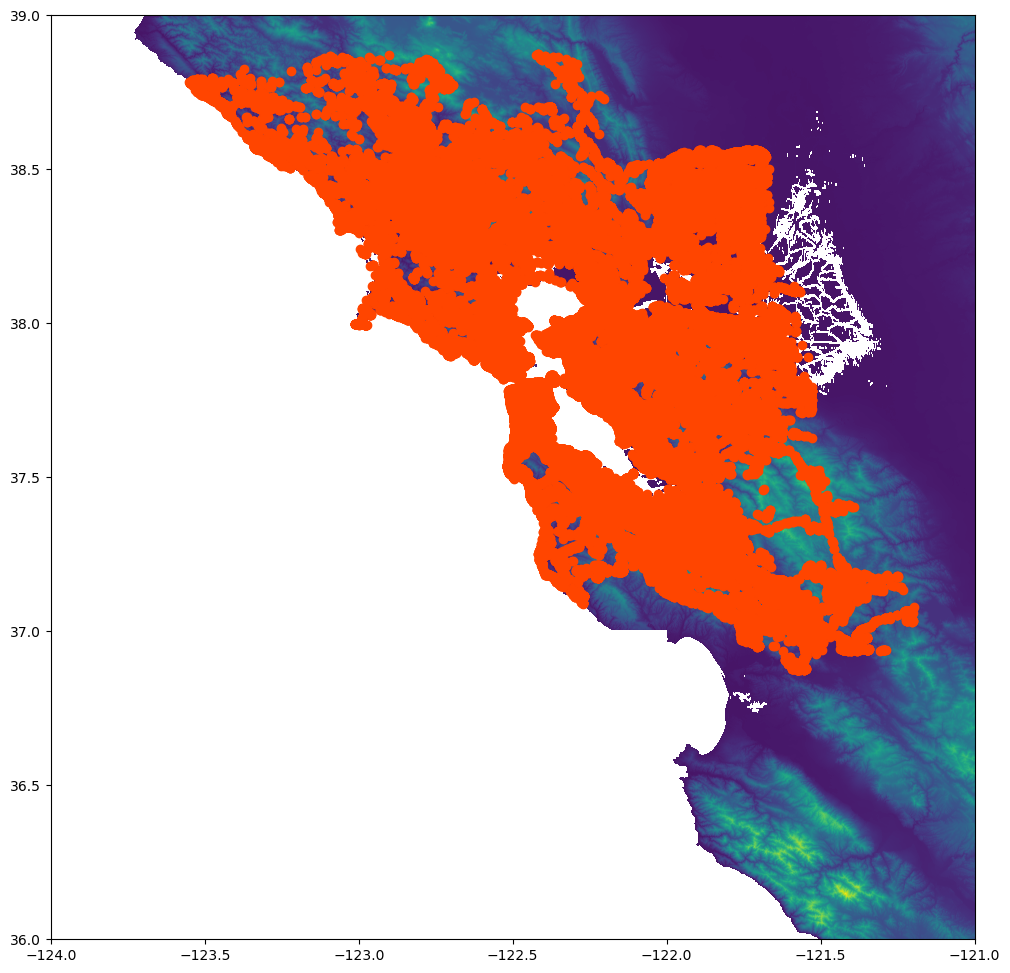

In [13]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [14]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["ROAD_ID","starting point"]]
sf1.columns=["ROAD_ID","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["ROAD_ID","geometry","start_lon","start_lat"]]
sf2.head(5)

,ROAD_ID,geometry,start_lon,start_lat
0,111276,POINT (-121.95749310000001 37.523941700000016),-121.957493,37.523942
1,162454,POINT (-121.7691832 37.3146411),-121.769183,37.314641
2,165633,POINT (-121.92277360000001 37.323369199999995),-121.922774,37.323369
3,888344,POINT (-122.24641819999998 37.78016040000001),-122.246418,37.780160
4,923150,POINT (-122.5192523 38.05433039999999),-122.519252,38.054330


In [15]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [16]:
sf2.head()

,ROAD_ID,geometry,start_lon,start_lat,starting_ele
0,111276,POINT (-121.95749310000001 37.523941700000016),-121.957493,37.523942,13
1,162454,POINT (-121.7691832 37.3146411),-121.769183,37.314641,110
2,165633,POINT (-121.92277360000001 37.323369199999995),-121.922774,37.323369,36
3,888344,POINT (-122.24641819999998 37.78016040000001),-122.246418,37.780160,5
4,923150,POINT (-122.5192523 38.05433039999999),-122.519252,38.054330,11


In [17]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["ROAD_ID","ending point"]]
ef1.columns=["ROAD_ID","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["ROAD_ID","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 9.61 s
Wall time: 9.6 s


,ROAD_ID,geometry,end_lon,end_lat
0,111276,POINT (-121.9572184 37.52396300000001),-121.957218,37.523963
1,162454,POINT (-121.76834140000001 37.3147661),-121.768341,37.314766
2,165633,POINT (-121.9223468 37.3233632),-121.922347,37.323363
3,888344,POINT (-122.2464029 37.78016710000001),-122.246403,37.780167
4,923150,POINT (-122.51929420000002 38.0543339),-122.519294,38.054334


In [18]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 3.77 s
Wall time: 3.77 s


In [19]:
lts_new.shape,sf2.shape,ef2.shape

((505029, 29), (505029, 5), (505029, 5))

In [20]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['ROAD_ID'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['ROAD_ID'], keep='first')
barea_all1.head()

CPU times: total: 3.86 s
Wall time: 3.87 s


,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_SEG_STR,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope
0,111276,POINT (-121.95749310000001 37.523941700000016),-121.957493,37.523942,13,POINT (-121.9572184 37.52396300000001),-121.957218,37.523963,13,{31439803},...,4.0,0,0,3.0,0,"LINESTRING (-121.95749 37.52394, -121.95722 37...",24.398252,POINT (-121.95749310000001 37.523941700000016),POINT (-121.9572184 37.52396300000001),0.000000
1,162454,POINT (-121.7691832 37.3146411),-121.769183,37.314641,110,POINT (-121.76834140000001 37.3147661),-121.768341,37.314766,113,{93291777},...,4.0,1.0,0,1.0,0,"LINESTRING (-121.76918 37.31464, -121.76834 37...",75.902661,POINT (-121.7691832 37.3146411),POINT (-121.76834140000001 37.3147661),3.952431
2,165633,POINT (-121.92277360000001 37.323369199999995),-121.922774,37.323369,36,POINT (-121.9223468 37.3233632),-121.922347,37.323363,36,{184388728},...,4.0,1.0,0,1.0,0,"LINESTRING (-121.92277 37.32337, -121.92235 37...",37.835842,POINT (-121.92277360000001 37.323369199999995),POINT (-121.9223468 37.3233632),0.000000
3,888344,POINT (-122.24641819999998 37.78016040000001),-122.246418,37.780160,5,POINT (-122.2464029 37.78016710000001),-122.246403,37.780167,5,{53726448},...,4.0,1.0,0,1.0,0,"LINESTRING (-122.24642 37.78016, -122.24640 37...",1.539394,POINT (-122.24641819999998 37.78016040000001),POINT (-122.2464029 37.78016710000001),0.000000
4,923150,POINT (-122.5192523 38.05433039999999),-122.519252,38.054330,11,POINT (-122.51929420000002 38.0543339),-122.519294,38.054334,11,{655711604},...,1.0,0,0,0,0,"LINESTRING (-122.51925 38.05433, -122.51929 38...",3.697954,POINT (-122.5192523 38.05433039999999),POINT (-122.51929420000002 38.0543339),0.000000


In [21]:
barea_all1.shape

(505029, 38)

In [22]:
barea_all1['slope'].describe()

count    5.050290e+05
mean     1.737539e+06
std      1.662065e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.423149e+00
max      4.825674e+10
Name: slope, dtype: float64

<AxesSubplot:>

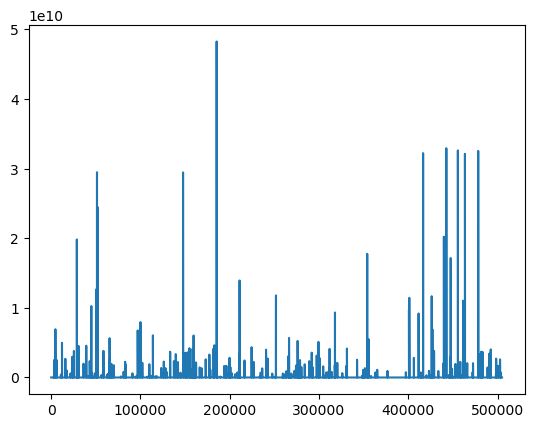

In [23]:
barea_all1.slope.plot()

In [24]:
# It seems that some of the slope is abnormal, due to mountain effect.

In [25]:
# Lets see the number of links that have slope greater than 100%
abnormal_slope=barea_all1.loc[barea_all1['slope']>100]
abnormal_slope.shape

(236, 38)

# Apply the slope effects for the LTS

In [26]:
abnormal_slope.columns

Index(['ROAD_ID', 'geometry_x', 'start_lon', 'start_lat', 'starting_ele',
       'geometry_y', 'end_lon', 'end_lat', 'ending_ele', 'osmid', 'FUNCTIONAL',
       'PATH_ID', 'ONE_WAY', 'u', 'v', 'WIDTH', 'SPEED_LIMI', 'FT_BIKE_IN',
       'FT_BIKE_01', 'TF_BIKE_IN', 'TF_BIKE_01', 'FT_LANES', 'TF_LANES',
       'FT_CROSS_L', 'TF_CROSS_L', 'TWLTL_CROS', 'FT_PARK', 'TF_PARK',
       'FT_SEG_STR', 'FT_INT_STR', 'TF_SEG_STR', 'TF_INT_STR', 'XWALK',
       'geometry', 'length', 'starting point', 'ending point', 'slope'],
      dtype='object')

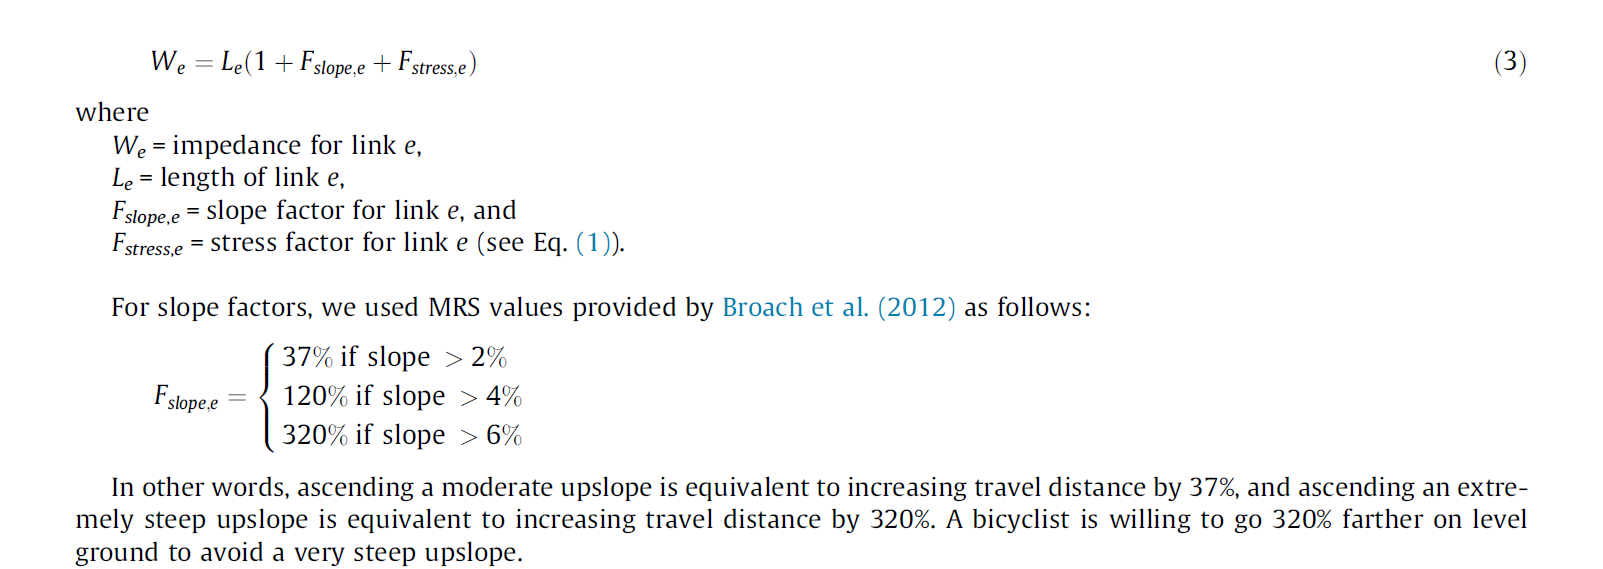

In [27]:
# write a slope impedance function
def slope_correction(length,FT_SEG_STR,slope):
    if slope <=2:
        return length*(1+FT_SEG_STR)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+FT_SEG_STR)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+FT_SEG_STR)
    else:
        return length*(1+3.20+FT_SEG_STR)

In [28]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['FT_SEG_STR']=pd.to_numeric(barea_all1['FT_SEG_STR']).astype(int)
barea_all1['FT_SEG_STR'].dtypes

dtype('int32')

In [29]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['FT_SEG_STR'],row['slope']),axis=1)
barea_all1.head(8)

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,111276,POINT (-121.95749310000001 37.523941700000016),-121.957493,37.523942,13,POINT (-121.9572184 37.52396300000001),-121.957218,37.523963,13,{31439803},...,0,0,3.0,0,"LINESTRING (-121.95749 37.52394, -121.95722 37...",24.398252,POINT (-121.95749310000001 37.523941700000016),POINT (-121.9572184 37.52396300000001),0.000000,121.991261
1,162454,POINT (-121.7691832 37.3146411),-121.769183,37.314641,110,POINT (-121.76834140000001 37.3147661),-121.768341,37.314766,113,{93291777},...,1.0,0,1.0,0,"LINESTRING (-121.76918 37.31464, -121.76834 37...",75.902661,POINT (-121.7691832 37.3146411),POINT (-121.76834140000001 37.3147661),3.952431,407.597287
2,165633,POINT (-121.92277360000001 37.323369199999995),-121.922774,37.323369,36,POINT (-121.9223468 37.3233632),-121.922347,37.323363,36,{184388728},...,1.0,0,1.0,0,"LINESTRING (-121.92277 37.32337, -121.92235 37...",37.835842,POINT (-121.92277360000001 37.323369199999995),POINT (-121.9223468 37.3233632),0.000000,189.179208
3,888344,POINT (-122.24641819999998 37.78016040000001),-122.246418,37.780160,5,POINT (-122.2464029 37.78016710000001),-122.246403,37.780167,5,{53726448},...,1.0,0,1.0,0,"LINESTRING (-122.24642 37.78016, -122.24640 37...",1.539394,POINT (-122.24641819999998 37.78016040000001),POINT (-122.2464029 37.78016710000001),0.000000,7.696969
4,923150,POINT (-122.5192523 38.05433039999999),-122.519252,38.054330,11,POINT (-122.51929420000002 38.0543339),-122.519294,38.054334,11,{655711604},...,0,0,0,0,"LINESTRING (-122.51925 38.05433, -122.51929 38...",3.697954,POINT (-122.5192523 38.05433039999999),POINT (-122.51929420000002 38.0543339),0.000000,7.395908
5,955824,POINT (-122.56019300000001 38.0143783),-122.560193,38.014378,17,POINT (-122.5598121 38.01426140000001),-122.559812,38.014261,17,{502817925},...,1.0,0,1.0,0,"LINESTRING (-122.56019 38.01438, -122.55981 38...",35.877744,POINT (-122.56019300000001 38.0143783),POINT (-122.5598121 38.01426140000001),0.000000,179.388721
6,463165,POINT (-121.9533115 37.769879400000015),-121.953311,37.769879,144,POINT (-121.9527144 37.76923669999999),-121.952714,37.769237,145,{758004215},...,1.0,0,1.0,0,"LINESTRING (-121.95331 37.76988, -121.95271 37...",88.638366,POINT (-121.9533115 37.769879400000015),POINT (-121.9527144 37.76923669999999),1.128180,177.276732
7,513383,POINT (-122.05951709999998 37.9342374),-122.059517,37.934237,22,POINT (-122.05967000000001 37.93478),-122.059670,37.934780,22,{792316869},...,0,0,0,0,"LINESTRING (-122.05952 37.93424, -122.05967 37...",61.709085,POINT (-122.05951709999998 37.9342374),POINT (-122.05967000000001 37.93478),0.000000,308.545424


# Lets Calculate the Connectivity for SF

In [30]:
# Bring US Census track
census_track=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/Bay_Area_Census_tracts.shp')
census_track.head()

,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,G0600010400100,06,001,400100,06001400100,4001,Census Tract 4001,G5020,S,6945857.0,0.0,+37.8676563,-122.2318813,14242.773440,14242.773440,6.945853e+06,"POLYGON ((-2255573.793 353162.591, -2255577.88..."
1,G0600010400200,06,001,400200,06001400200,4002,Census Tract 4002,G5020,S,586560.0,0.0,+37.8481378,-122.2495916,3990.700032,3990.700032,5.865583e+05,"POLYGON ((-2258184.246 353217.527, -2258186.81..."
2,G0600010400300,06,001,400300,06001400300,4003,Census Tract 4003,G5020,S,1110840.0,0.0,+37.8405841,-122.2544782,5311.191050,5311.191050,1.110836e+06,"POLYGON ((-2259381.804 351835.858, -2259385.23..."
3,G0600010400400,06,001,400400,06001400400,4004,Census Tract 4004,G5020,S,716138.0,0.0,+37.8482840,-122.2574447,3812.082499,3812.082499,7.161367e+05,"POLYGON ((-2259084.126 353696.375, -2259085.36..."
4,G0600010400500,06,001,400500,06001400500,4005,Census Tract 4005,G5020,S,591424.0,0.0,+37.8485452,-122.2647353,3292.829056,3292.829056,5.914232e+05,"POLYGON ((-2259833.634 353763.276, -2259822.21..."


<AxesSubplot:>

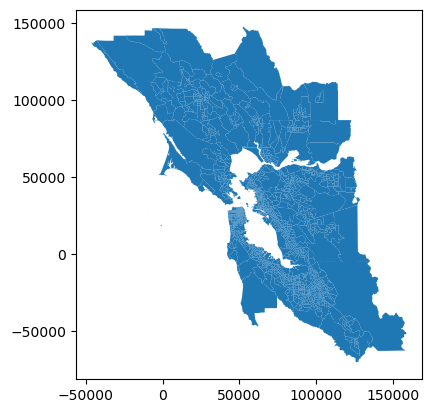

In [31]:
census_track1=census_track.to_crs(epsg=7131)
census_track1.plot()

In [32]:
# read the alamedo boundary shape file
study_bd=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/geo_export_b69ec18e-6a40-4637-94f6-1f3aafe63144.shp")
study_bd

,county,fipsstco,objectid,geometry
0,Alameda,06001,1.0,"MULTIPOLYGON (((-122.21496 37.76113, -122.2156..."
1,Contra Costa,06013,2.0,"MULTIPOLYGON (((-121.95091 38.05392, -121.9505..."
2,Marin,06041,3.0,"MULTIPOLYGON (((-122.86959 38.02140, -122.8711..."
3,Napa,06055,4.0,"POLYGON ((-122.20246 38.68898, -122.20232 38.6..."
4,San Francisco,06075,5.0,"MULTIPOLYGON (((-122.47738 37.81103, -122.4763..."
5,San Mateo,06081,6.0,"MULTIPOLYGON (((-122.50248 37.70813, -122.4977..."
6,Santa Clara,06085,7.0,"MULTIPOLYGON (((-122.02427 37.46094, -122.0203..."
7,Solano,06095,8.0,"MULTIPOLYGON (((-122.01053 38.09290, -122.0110..."
8,Sonoma,06097,9.0,"MULTIPOLYGON (((-123.53354 38.76841, -123.5333..."


In [33]:
# lets consider only Alameda for now
sf_bd=study_bd.loc[study_bd['county']=='San Francisco']
sf_bd1=gpd.GeoDataFrame.explode(sf_bd)
sf_bd1

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4088136457.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_bd1=gpd.GeoDataFrame.explode(sf_bd)


county fipsstco  objectid  \
4 0   San Francisco    06075       5.0   
  1   San Francisco    06075       5.0   
  2   San Francisco    06075       5.0   
  3   San Francisco    06075       5.0   
  4   San Francisco    06075       5.0   
  5   San Francisco    06075       5.0   
  6   San Francisco    06075       5.0   
  7   San Francisco    06075       5.0   
  8   San Francisco    06075       5.0   
  9   San Francisco    06075       5.0   
  10  San Francisco    06075       5.0   
  11  San Francisco    06075       5.0   
  12  San Francisco    06075       5.0   
  13  San Francisco    06075       5.0   
  14  San Francisco    06075       5.0   
  15  San Francisco    06075       5.0   
  16  San Francisco    06075       5.0   
  17  San Francisco    06075       5.0   
  18  San Francisco    06075       5.0   

                                               geometry  
4 0   POLYGON ((-122.47738 37.81103, -122.47638 37.8...  
  1   POLYGON ((-122.36716 37.82919, -122.36708 37.8...  
  2   POLYGON ((-123.00111 37.69519, -123.00253 37.6...  
  3   POLYGON ((-122.33228 37.78813, -122.32768 37.7...  
  4   POLYGON ((-123.01348 37.70000, -123.01327 37.7...  
  5   POLYGON ((-122.42168 37.82513, -122.42248 37.8...  
  6   POLYGON ((-122.41988 37.86043, -122.42038 37.8...  
  7   POLYGON ((-122.51621 37.77863, -122.51602 37.7...  
  8   POLYGON ((-123.10751 37.77175, -123.10713 37.7...  
  9   POLYGON ((-123.00360 37.69325, -123.00409 37.6...  
  10  POLYGON ((-122.51703 37.78032, -122.51692 37.7...  
  11  POLYGON ((-123.00385 37.70327, -123.00371 37.7...  
  12  POLYGON ((-123.09955 37.76754, -123.09940 37.7...  
  13  POLYGON ((-123.09761 37.76365, -123.09781 37.7...  
  14  POLYGON ((-123.10096 37.76654, -123.10087 37.7...  
  15  POLYGON ((-123.03263 37.72712, -123.03251 37.7...  
  16  POLYGON ((-122.38078 37.76023, -122.38098 37.7...  
  17  POLYGON ((-123.00431 37.70211, -123.00454 37.7...  
  18  POLYGON ((-123.00564 37.70277, -123.00564 37.7...

In [34]:
sf_bd1.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

<AxesSubplot:>

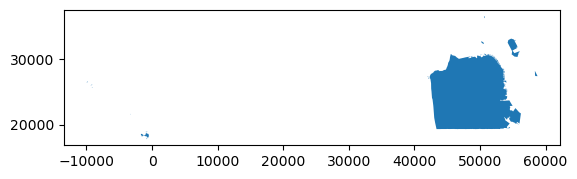

In [35]:
sf_bd_proj = sf_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [36]:
sf_bd_proj

,county,fipsstco,objectid,geometry
4,San Francisco,06075,5.0,"MULTIPOLYGON (((45588.708 30774.040, 45676.760..."


In [37]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

,county,fipsstco,objectid,geometry,area
4,San Francisco,06075,5.0,"MULTIPOLYGON (((45588.708 30774.040, 45676.760...",47.579463


In [38]:
sf_area=sf_bd_proj[['area']].values
sf_area

array([[47.57946255]])

In [39]:
# Convert to geodataframe
#abnormal_slope1=abnormal_slope.set_crs(epsg=4326)
#abnormal_slope2=abnormal_slope1.to_crs(epsg=7131)
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,111276,POINT (-121.95749310000001 37.523941700000016),-121.957493,37.523942,13,POINT (-121.9572184 37.52396300000001),-121.957218,37.523963,13,{31439803},...,0,0,3.0,0,"LINESTRING (91536.677 -976.326, 91560.948 -973...",24.398252,POINT (-121.95749310000001 37.523941700000016),POINT (-121.9572184 37.52396300000001),0.000000,121.991261
1,162454,POINT (-121.7691832 37.3146411),-121.769183,37.314641,110,POINT (-121.76834140000001 37.3147661),-121.768341,37.314766,113,{93291777},...,1.0,0,1.0,0,"LINESTRING (108350.827 -24102.437, 108425.349 ...",75.902661,POINT (-121.7691832 37.3146411),POINT (-121.76834140000001 37.3147661),3.952431,407.597287
2,165633,POINT (-121.92277360000001 37.323369199999995),-121.922774,37.323369,36,POINT (-121.9223468 37.3233632),-121.922347,37.323363,36,{184388728},...,1.0,0,1.0,0,"LINESTRING (94730.324 -23220.754, 94768.157 -2...",37.835842,POINT (-121.92277360000001 37.323369199999995),POINT (-121.9223468 37.3233632),0.000000,189.179208
3,888344,POINT (-122.24641819999998 37.78016040000001),-122.246418,37.780160,5,POINT (-122.2464029 37.78016710000001),-122.246403,37.780167,5,{53726448},...,1.0,0,1.0,0,"LINESTRING (65934.473 27367.107, 65935.819 273...",1.539394,POINT (-122.24641819999998 37.78016040000001),POINT (-122.2464029 37.78016710000001),0.000000,7.696969
4,923150,POINT (-122.5192523 38.05433039999999),-122.519252,38.054330,11,POINT (-122.51929420000002 38.0543339),-122.519294,38.054334,11,{655711604},...,0,0,0,0,"LINESTRING (41921.847 57781.540, 41918.170 577...",3.697954,POINT (-122.5192523 38.05433039999999),POINT (-122.51929420000002 38.0543339),0.000000,7.395908


In [40]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
263283,918176,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,{287653454},...,1.0,1.0,1.0,0,"LINESTRING (43314.360 20024.235, 43312.129 200...",22.655456,POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),4.413948,72.497459
265885,918177,POINT (-122.50314150000001 37.7141678),-122.503142,37.714168,56,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,{287653454},...,1.0,1.0,1.0,0,"LINESTRING (43314.360 20024.235, 43313.375 200...",10.679609,POINT (-122.50314150000001 37.7141678),POINT (-122.5032185 37.71423329999999),9.363638,55.533969
4037,918179,POINT (-122.5032306 37.7143644),-122.503231,37.714364,58,POINT (-122.5032185 37.71423329999999),-122.503219,37.714233,55,{287653461},...,1.0,1.0,0,0,"LINESTRING (43306.516 20046.060, 43307.361 200...",17.253511,POINT (-122.5032306 37.7143644),POINT (-122.5032185 37.71423329999999),17.387765,89.718260
111693,958473,POINT (-122.5023662 37.7142981),-122.502366,37.714298,56,POINT (-122.5011292 37.714855500000006),-122.501129,37.714856,56,{506575391},...,1.0,1.0,0,0,"LINESTRING (43382.729 20038.659, 43389.392 200...",131.803597,POINT (-122.5023662 37.7142981),POINT (-122.5011292 37.714855500000006),0.000000,263.607195
731,850531,POINT (-122.50309500000002 37.7245216),-122.503095,37.724522,15,POINT (-122.5003349 37.7190734),-122.500335,37.719073,20,"{89770058,397084691,284557517}",...,0,0,0,0,"LINESTRING (43319.112 21173.421, 43320.506 211...",666.102808,POINT (-122.50309500000002 37.7245216),POINT (-122.5003349 37.7190734),0.750635,3330.514041


In [41]:
sf_lts.groupby(['FT_BIKE_IN']).count()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
FT_BIKE_IN,,,,,,,,,,,,,,,,,,,,,
0,21371,21371,21371,21371,21371,21371,21371,21371,21371,21371,...,21371,21371,21371,21371,21371,21371,21371,21371,21371,21371
buffered_lane,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
lane,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374,...,2374,2374,2374,2374,2374,2374,2374,2374,2374,2374
path,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052,...,2052,2052,2052,2052,2052,2052,2052,2052,2052,2052
sharrow,2941,2941,2941,2941,2941,2941,2941,2941,2941,2941,...,2941,2941,2941,2941,2941,2941,2941,2941,2941,2941
track,667,667,667,667,667,667,667,667,667,667,...,667,667,667,667,667,667,667,667,667,667


In [42]:
sf_lts.crs

<Derived Projected CRS: EPSG:7131>
Name: NAD83(2011) / San Francisco CS13
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California - San Francisco bay area - counties of Alameda, Contra Costa, Marin, Napa, San Francisco, San Mateo, Santa Clara, Santa Cruz, Solano and Sonoma.
- bounds: (-123.56, 36.85, -121.2, 38.87)
Coordinate Operation:
- name: City and County of San Francisco CS13 (meters)
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [43]:
lts.shape

(505029, 27)

In [44]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\1286791951.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)


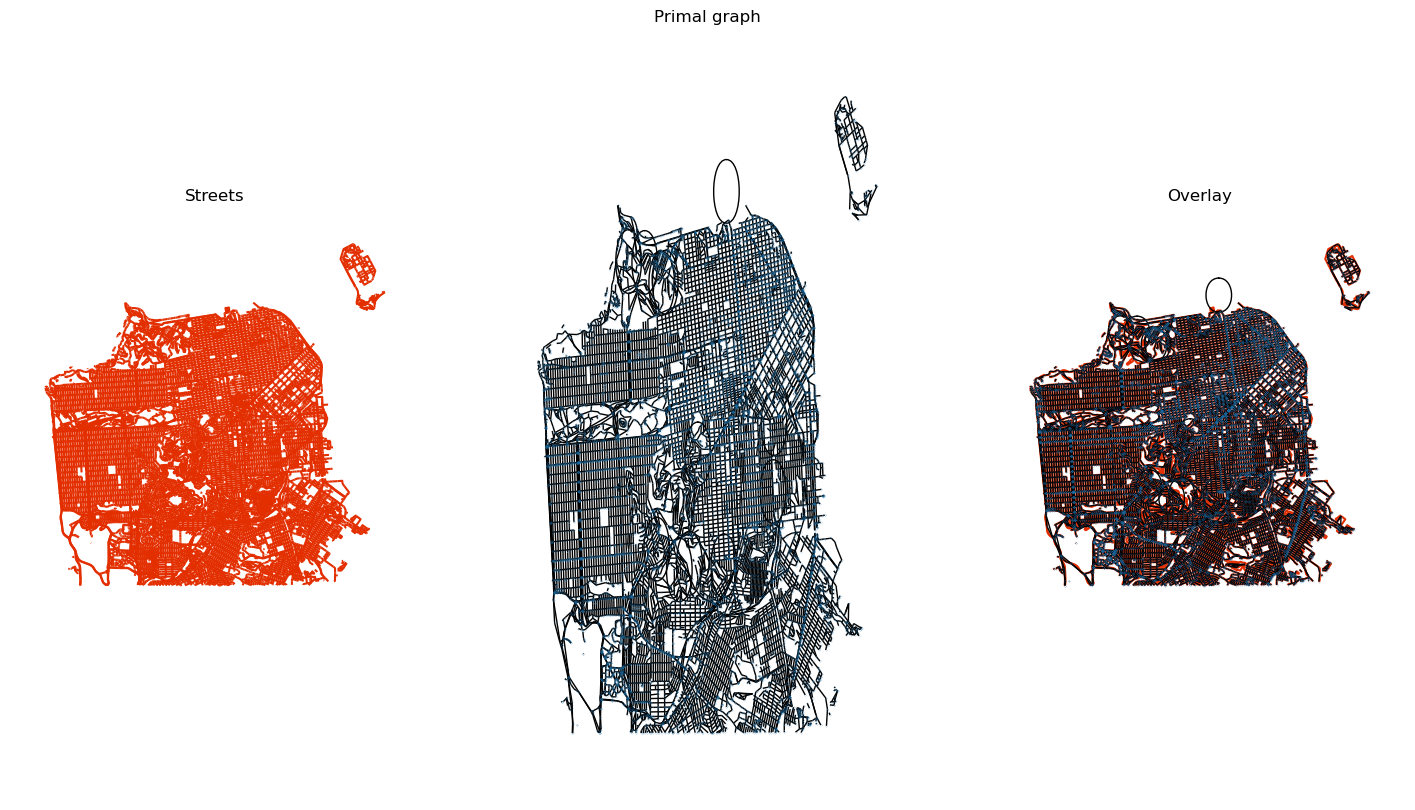

In [45]:
 f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
 sf_lts.plot(color='#e32e00', ax=ax[0])
 for i, facet in enumerate(ax):
     facet.set_title(("Streets", "Primal graph", "Overlay")[i])
     facet.axis("off")
 nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
 sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
 nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

# Calculate Simple Graph Theories Connectivity for SF

<AxesSubplot:>

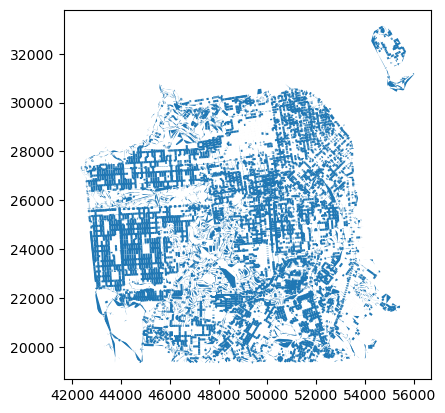

In [46]:
sf_lts['geometry'].convex_hull.plot()

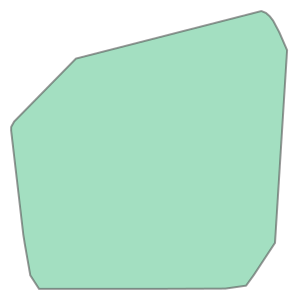

In [47]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot:>

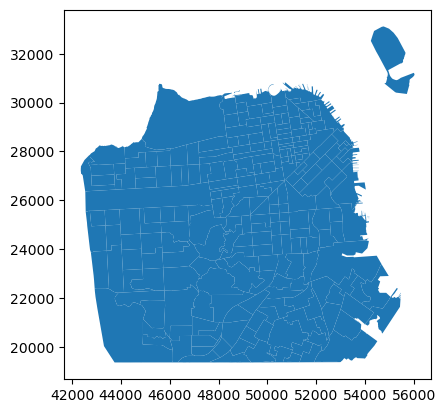

In [48]:
census_track2_sf=gpd.clip(census_track1,convex_hull_area)
census_track2_sf.plot()

In [49]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

153822724.40009806

In [50]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]


In [51]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [52]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

9571

# Calculate the Connectivity of the SF Network: using Formula "Shortest Path in bicycle facilities /Shortest Path in motor ways

In [53]:
sf_lts['FT_BIKE_IN'].dtypes

dtype('O')

<AxesSubplot:>

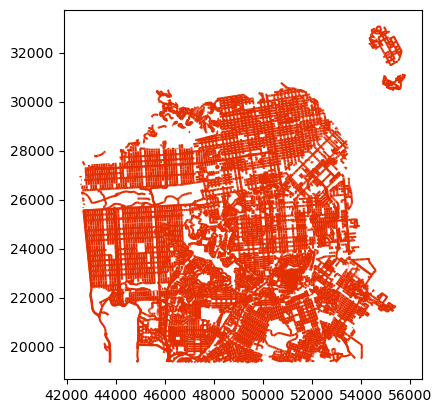

In [54]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['FT_BIKE_IN']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

<AxesSubplot:>

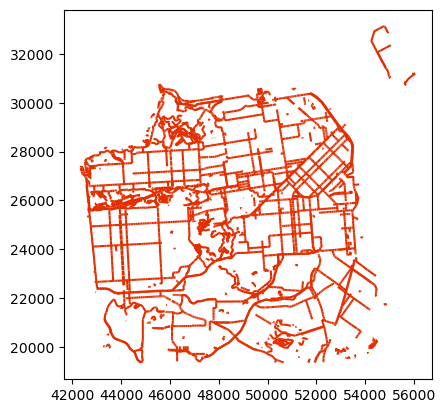

In [55]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['FT_BIKE_IN']!='0']
sf_bike_network.plot(color='#e32e00')

In [56]:
sf_lts.shape, sf_bike_network.shape, sf_motor_network.shape

((29407, 39), (8036, 39), (21371, 39))

In [57]:
sf_bike_network.tail()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
477492,918870,POINT (-122.4360389 37.80671190000001),-122.436039,37.806712,3,POINT (-122.4358576 37.806734799999994),-122.435858,37.806735,4,{302293972},...,0,1.0,0,0,"LINESTRING (49229.458 30294.719, 49245.423 302...",16.166896,POINT (-122.4360389 37.80671190000001),POINT (-122.4358576 37.806734799999994),6.185479,84.067862
11272,872092,POINT (-122.42955480000002 37.806916199999996),-122.429555,37.806916,24,POINT (-122.4297038 37.8065213),-122.429704,37.806521,23,"{24526157,186433173}",...,1.0,1.0,0,0,"LINESTRING (49800.463 30317.500, 49796.766 303...",45.778413,POINT (-122.42955480000002 37.806916199999996),POINT (-122.4297038 37.8065213),2.184436,108.494840
402725,877519,POINT (-122.4320032 37.80710220000001),-122.432003,37.807102,5,POINT (-122.4320737 37.8070077),-122.432074,37.807008,5,{641730768},...,0,1.0,0,0,"LINESTRING (49584.846 30338.101, 49586.530 303...",17.177908,POINT (-122.4320032 37.80710220000001),POINT (-122.4320737 37.8070077),0.000000,34.355815
351521,904036,POINT (-122.4293132 37.8073072),-122.429313,37.807307,25,POINT (-122.42955480000002 37.806916199999996),-122.429555,37.806916,24,{24526157},...,0,1.0,1.0,0,"LINESTRING (49821.729 30360.904, 49819.907 303...",48.499635,POINT (-122.4293132 37.8073072),POINT (-122.42955480000002 37.806916199999996),2.061871,114.944136
409282,877522,POINT (-122.4298589 37.8076189),-122.429859,37.807619,5,POINT (-122.4320032 37.80710220000001),-122.432003,37.807102,5,{641730768},...,0,1.0,0,0,"LINESTRING (49773.666 30395.490, 49746.374 305...",971.101411,POINT (-122.4298589 37.8076189),POINT (-122.4320032 37.80710220000001),0.000000,1942.202823


In [58]:
def sf_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()


    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total motor path
    sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

    #connectivity score
    sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
    connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [59]:
def graph_parameter(sf_motor_network,cul_de_sacs,convex_hull_area1,sf_area):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    # Calculate the number of Intersections
    crossroad_nodes = [node for node in sf_lts_motor_g1.nodes() if len(sf_lts_motor_g1.edges(node)) > 2]
    # Number of intersections where edge>2
    NI=get_number_of_elements(crossroad_nodes)
    # Calculate the parameters that we need
    edge_length_total1=sf_lts_motor_g.geometry.length.sum()
    street_segment_count1=sf_lts_motor_g1.number_of_edges()
    n1=sf_lts_motor_g1.number_of_nodes()
    sn=nx.number_connected_components(sf_lts_motor_g1)
#    cul_de_sacs=1102 # used cul-de-scas function from ArcGIS Pro
    
    Street_density=(edge_length_total1*0.000621371)/(convex_hull_area1*3.861e-7) # mile/square mile
    Intersection_density=(NI/convex_hull_area1*3.861e-7) # per mile square
    Street_density_by_land_area=(edge_length_total1*0.000621371)/(sf_area) # mile/square mile
    Intersection_density_by_land_area=(NI/sf_area) # per mile square
    CNR=(NI/(NI+cul_de_sacs))
    alpha=(street_segment_count1-n1+sn)/(2*n1-5)
    beta=street_segment_count1/n1
    gamma=street_segment_count1/(3*n1-2)
    eta=edge_length_total1/street_segment_count1
    GTP=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)
    Cyclomatic_Number=street_segment_count1-n1+1
    Aggregate_TP_score=alpha+beta+gamma+Cyclomatic_Number
    
    connectivity_score.append((NI,street_segment_count1,n1,sn,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,Cyclomatic_Number,Aggregate_TP_score))
    cols=['Number of Intersection','street_segment_count','Number of Node','Number of subnetwork','Street_density','Intersection_density','Street_density_by_land_area','Intersection_density_by_land_area','CNR','alpha','beta','gamma','eta','GTP','cyclomatic_Number','Aggregate_TP_score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result

In [60]:
%%time
# Calculate the graph parameter for bike network for SF
bike_network_score=graph_parameter(sf_bike_network,1946,convex_hull_area1,sf_area)
bike_network_score['mode']='bike'
bike_network_score

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4031221608.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)


CPU times: total: 781 ms
Wall time: 780 ms


,Number of Intersection,street_segment_count,Number of Node,Number of subnetwork,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,cyclomatic_Number,Aggregate_TP_score,mode
0,1077,8062,7943,283,5.191148,2.703305e-12,[[6.479838915786467]],[[22.635816849335026]],0.356269,0.025313,1.014982,0.338356,61.544602,0.051766,120,121.378651,bike


In [61]:
%%time
# Calculate the graph parameter for motor network for SF
motor_network_score=graph_parameter(sf_motor_network,1102,convex_hull_area1,sf_area)
motor_network_score['mode']='motor'
motor_network_score

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4031221608.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)


CPU times: total: 2 s
Wall time: 1.99 s


,Number of Intersection,street_segment_count,Number of Node,Number of subnetwork,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,cyclomatic_Number,Aggregate_TP_score,mode
0,6008,21377,17898,181,15.084114,1.508027e-11,[[18.828710270394737]],[[126.27296901653187]],0.845007,0.10226,1.194379,0.398141,67.443852,0.207584,3480,3481.694781,motor


In [62]:
%%time
# Calculate the graph parameter for complete network for SF
motor_network_score=graph_parameter(sf_lts,1377,convex_hull_area1,sf_area)
motor_network_score['mode']='motor'
motor_network_score

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4031221608.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)


CPU times: total: 3.27 s
Wall time: 3.26 s


,Number of Intersection,street_segment_count,Number of Node,Number of subnetwork,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,cyclomatic_Number,Aggregate_TP_score,mode
0,9571,29439,22846,152,20.275262,2.402352e-11,[[25.308549186181203]],[[201.1582201160497]],0.874224,0.147635,1.288584,0.429541,65.828316,0.299183,6594,6595.86576,motor


In [63]:
%%time
## Calculate the connectivity score for bike vs motor network condition
sf_connectivity_score (sf_motor_network,sf_bike_network)

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


CPU times: total: 23min 34s
Wall time: 23min 34s


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,7.342455e+12,9.913353e+11,0.135014


# Calculate the connectivity score for the census track level of the SF Network

In [64]:
# # Define grid
# def make_grid(sample_sublink,m,n):
#     xmin,ymin,xmax,ymax = sample_sublink.total_bounds
#     width = (xmax-xmin)/m
#     height = (ymax-ymin)/n
#     rows = int(np.ceil((ymax-ymin) / height))
#     cols = int(np.ceil((xmax-xmin) / width))
#     XleftOrigin = xmin
#     XrightOrigin = xmin + width
#     YtopOrigin = ymax
#     YbottomOrigin = ymax - height
#     polygons = []

#     for i in range(cols):
#         Ytop = YtopOrigin
#         Ybottom =YbottomOrigin
#         for j in range(rows):
#             polygons.append(Polygon([(XleftOrigin, Ytop), (XrightOrigin, Ytop), (XrightOrigin, Ybottom), (XleftOrigin, Ybottom)])) 
#             Ytop = Ytop - height
#             Ybottom = Ybottom - height
#         XleftOrigin = XleftOrigin + width
#         XrightOrigin = XrightOrigin + width

#     grid = gpd.GeoDataFrame({'geometry':polygons})
#     grid1=grid.set_crs('EPSG:7131')
#     return grid1

In [65]:
# Make a bigger grid which will be initial input of for loop
# m=2 # input m value here
# n=2 # input n value here
# grid_sf=make_grid(sf_lts_g,m,n)
# #grid_motor['Block_ID']=grid_motor.index
# grid_sf

<AxesSubplot:>

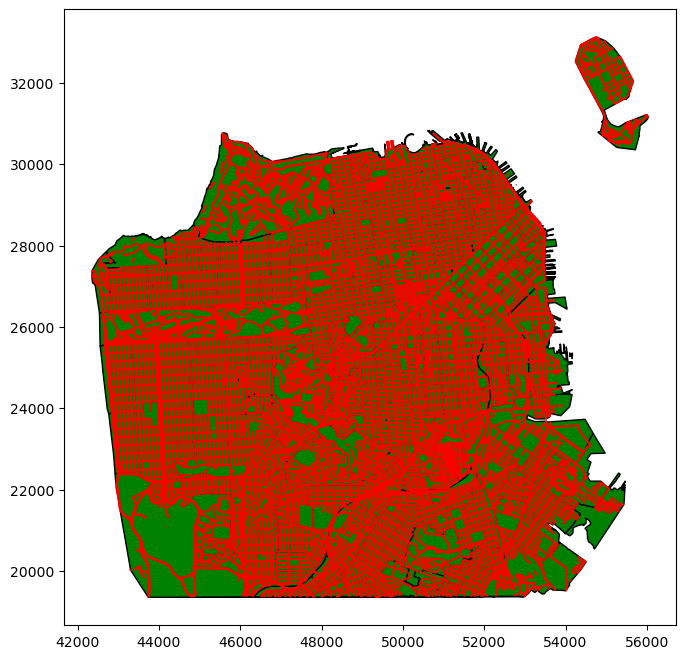

In [66]:
fig, ax = plt.subplots(figsize = (8,8)) 
census_track2_sf.plot(ax=ax,color="green",edgecolor='k')
sf_lts.geometry.plot(color="red",edgecolor='k',ax=ax)

In [67]:
input_census_tract=census_track2_sf.reset_index()
input_census_tract.shape

(248, 18)

In [68]:
def grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network):
    
    connectivity_score=[]

    for index, row in input_census_tract.iterrows():
        network_motor=gpd.clip(sf_motor_network,row['geometry'])
        sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
        sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
        # Calculate the total motor path
        sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()



        network_bike=gpd.clip(sf_bike_network,row['geometry'])
        sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
        sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
        # Calculate the total motor path
        sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

        #connectivity score
        sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
        connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [69]:
%%time
SF_CS=grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network)
SF_CS.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

CPU times: total: 22.6 s
Wall time: 22.6 s


C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,4.211768e+03,642.713449,0.152599
1,2.390986e+03,1994.666912,0.834244
2,4.706074e+06,858.882341,0.000183
3,6.551422e+06,207612.725827,0.031690
4,5.450928e+06,1028.247225,0.000189


In [62]:
# Now jointhe connectivity score with census track and save it

In [63]:
cs_census_track=pd.merge(SF_CS, input_census_tract, left_index=True, right_index=True)
cs_census_track.head()

,motor_path_weighted_length,bike_path_weighted_length,Connectivity score,index,GISJOIN,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,...,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,4.211768e+03,642.713449,0.152599,980,G0600810600100,06,081,600100,06081600100,6001,...,G5020,S,14582823.0,2117772.0,+37.6877413,-122.4084093,21931.580332,21901.907257,1.502156e+07,"POLYGON ((51942.346 19368.351, 51943.438 19368..."
1,2.390986e+03,1994.666912,0.834244,981,G0600810600200,06,081,600200,06081600200,6002,...,G5020,S,1137963.0,0.0,+37.7044761,-122.4157978,5484.725579,5484.726024,1.137960e+06,"POLYGON ((50662.857 19364.399, 50717.529 19364..."
2,4.706074e+06,858.882341,0.000183,891,G0600750026404,06,075,026404,06075026404,264.04,...,G5020,S,189179.0,0.0,+37.7096507,-122.4152933,2097.988325,2097.988325,1.891781e+05,"POLYGON ((51353.615 19473.311, 51330.274 19407..."
3,6.551422e+06,207612.725827,0.031690,890,G0600750026403,06,075,026403,06075026403,264.03,...,G5020,S,379501.0,0.0,+37.7111907,-122.4069124,3003.969753,3003.969753,3.795004e+05,"POLYGON ((52162.578 19802.437, 52134.636 19783..."
4,5.450928e+06,1028.247225,0.000189,888,G0600750026401,06,075,026401,06075026401,264.01,...,G5020,S,341043.0,0.0,+37.7135251,-122.4112834,2825.654952,2825.654952,3.410432e+05,"POLYGON ((51495.157 20270.624, 51532.106 20257..."


In [64]:
cs_census_track['Connectivity score'].median()

0.032462512102624956

In [360]:
crs = {'init': 'epsg:7131'}
gdf = gpd.GeoDataFrame(cs_census_track, crs=crs, geometry = 'geometry')
gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF_Census_track_level_CS.shp")

# Consider high Stress Vs Low Stress connectivity: using Formula "Shortest Path(LTS1+LTS2)/Shortest Path (LTS1+LTS2+LTS3+LTS4-All Bicycle Facilities)

In [ ]:
# comments: Here all high stress is changed to Motor Network

In [70]:
# Split the network as low  stress network to get the connectivity 
sf_motor_network_op2=sf_motor_network
sf_bike_network_op2=sf_lts.loc[sf_lts['FT_SEG_STR']<3]

In [71]:
%%time
# low stress connectivity
low_stress_network_score=graph_parameter(sf_bike_network_op2,415,convex_hull_area1,sf_area)
low_stress_network_score['mode']='low_stress'
low_stress_network_score

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4031221608.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)


CPU times: total: 1.66 s
Wall time: 1.65 s


,Number of Intersection,street_segment_count,Number of Node,Number of subnetwork,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,cyclomatic_Number,Aggregate_TP_score,mode
0,4481,17474,15835,519,13.376935,1.124745e-11,[[16.697727897516558]],[[94.17928997388138]],0.915237,0.068151,1.103505,0.36785,73.170092,0.138472,1640,1641.539506,low_stress


In [72]:
%%time
# motor network  connectivity
high_stress_network_score=graph_parameter(sf_motor_network_op2,1102,convex_hull_area1,sf_area)
high_stress_network_score['mode']='Motor Network'
high_stress_network_score

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\4031221608.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)


CPU times: total: 2 s
Wall time: 2 s


,Number of Intersection,street_segment_count,Number of Node,Number of subnetwork,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,cyclomatic_Number,Aggregate_TP_score,mode
0,6008,21377,17898,181,15.084114,1.508027e-11,[[18.828710270394737]],[[126.27296901653187]],0.845007,0.10226,1.194379,0.398141,67.443852,0.207584,3480,3481.694781,Motor Network


In [73]:
%%time
# low stress Vs motor network connectivity score
low_high_stress_CS=sf_connectivity_score (sf_motor_network_op2,sf_bike_network_op2)
low_high_stress_CS

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_11504\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


CPU times: total: 29min
Wall time: 29min 13s


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,7.342455e+12,2.421603e+12,0.329808


In [69]:
%%time
# Calculate the census level stress for high vs low stress network
SF_CS_hl=grid_connectivity_score (input_census_tract,sf_bike_network_op2,sf_motor_network_op2)
SF_CS_hl.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarnin

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

CPU times: total: 31.5 s
Wall time: 31.6 s


,motor_path_weighted_length,bike_path_weighted_length,Connectivity score
0,0.000000e+00,4.211768e+03,inf
1,3.751135e+03,2.390986e+03,0.637403
2,4.657295e+06,4.706074e+06,1.010474
3,4.668844e+06,6.551422e+06,1.403221
4,5.156212e+06,5.450928e+06,1.057157


In [72]:
SF_CS_hl['Connectivity score'].median()

2.4587727401264736

In [71]:
cs_census_track_hl=pd.merge(SF_CS_hl, input_census_tract, left_index=True, right_index=True)
crs = {'init': 'epsg:7131'}
gdf_hl = gpd.GeoDataFrame(cs_census_track_hl, crs=crs, geometry = 'geometry')
gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF_Census_track_level_CS_low_vs_motor.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\2410027840.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF_Census_track_level_CS_low_vs_motor.shp")


# Calculate Advanced graph Connectivity

## Degree Centrality

In [73]:
# Calculate the Connectivity By LTS classification
sf_motor_network_op2=sf_motor_network
# Convert the LTS shape file to graph to run the 
sf_lts_motor_g_op2=gpd.GeoDataFrame.explode(sf_motor_network_op2)
sf_lts_motor_g1_op2 =momepy.gdf_to_nx(sf_lts_motor_g_op2, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\1554712526.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g_op2=gpd.GeoDataFrame.explode(sf_motor_network_op2)


In [74]:
degree = dict(nx.degree(sf_lts_motor_g1_op2))
nx.set_node_attributes(sf_lts_motor_g1_op2, degree, 'degree')

In [75]:
from numpy import array
print('min_dc:', array([degree[k] for k in degree]).min())
print('mean_dc:',array([degree[k] for k in degree]).mean())
print('max_dc:',array([degree[k] for k in degree]).max())
print('std_dc:',array([degree[k] for k in degree]).std())

min_dc: 1
mean_dc: 2.3887585205050845
max_dc: 6
std_dc: 0.8897492434946724


In [76]:
nodes, edges = momepy.nx_to_gdf(sf_lts_motor_g1_op2)

In [77]:
edges=edges.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [78]:
nodes.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_nodes_sf_motor_network.shp")
edges.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_sf_motor_network.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\2125986196.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_sf_motor_network.shp")


In [ ]:
nodes.shape, edges.shape

In [214]:
### Lets do the same thing for low stress
# Calculate the Connectivity By LTS classification
sf_bike_network_op2=sf_lts.loc[sf_lts['FT_SEG_STR']<3]
# Convert the LTS shape file to graph to run the 
sf_lts_bike_g_op2=gpd.GeoDataFrame.explode(sf_bike_network_op2)
sf_lts_bike_g1_op2 =momepy.gdf_to_nx(sf_lts_bike_g_op2, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\1843893756.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g_op2=gpd.GeoDataFrame.explode(sf_bike_network_op2)


In [215]:
degreel = dict(nx.degree(sf_lts_bike_g1_op2))
nx.set_node_attributes(sf_lts_bike_g1_op2, degreel, 'degree')

In [217]:
nodesl, edgesl = momepy.nx_to_gdf(sf_lts_bike_g1_op2)
edgesl=edgesl.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [218]:
nodesl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_nodes_ls_sf.shp")
edgesl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_ls_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\412474853.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edgesl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_ls_sf.shp")


In [219]:
nodesl.shape, edgesl.shape

((15835, 3), (17474, 33))

In [69]:
%%time
# run the Degree centrality for complete Network
degree2 = dict(nx.degree(sf_lts_g1))
nx.set_node_attributes(sf_lts_g1, degree2, 'degree')
nodes2, edges2 = momepy.nx_to_gdf(sf_lts_g1)
edges2=edges2.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)
#nodes2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_nodes_sf_complete_network.shp")
#edges2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/degree_edges_sf_complete_network.shp")

CPU times: total: 1.86 s
Wall time: 1.85 s


In [70]:
from numpy import array
print('min_dc:', array([degree2[k] for k in degree2]).min())
print('mean_dc:',array([degree2[k] for k in degree2]).mean())
print('max_dc:',array([degree2[k] for k in degree2]).max())
print('std_dc:',array([degree2[k] for k in degree2]).std())

min_dc: 1
mean_dc: 2.5771688698240394
max_dc: 7
std_dc: 0.9094870737915214


In [71]:
nodes2.shape, edges2.shape

((22846, 3), (29439, 33))

# Lets Calculate th LTS weighted Eigenvector Centrality

In [95]:
%%time
D = ox.utils_graph.get_digraph(sf_lts_bike_g1_op2, weight="impedance_of_link")
Eigene_centrality_ls = nx.eigenvector_centrality(D,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(sf_lts_bike_g1_op2, values=Eigene_centrality_ls, name="Eigene_centrality")

NameError: name 'sf_lts_bike_g1_op2' is not defined

In [228]:
nodes_ecl, edges_ecl = momepy.nx_to_gdf(sf_lts_bike_g1_op2)


In [231]:
edges_ecl=edges_ecl.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [253]:
nodes_ecl['EC_group'] = pd.cut(nodes_ecl['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ecl.tail()

,degree,nodeID,Eigene_centrality,geometry,EC_group
15830,2,15830,0.0,POINT (49229.458 30294.719),1
15831,1,15831,0.0,POINT (49245.423 30297.263),1
15832,2,15832,0.0,POINT (49800.463 30317.500),1
15833,2,15833,0.0,POINT (49584.846 30338.101),1
15834,1,15834,0.0,POINT (49773.666 30395.490),1


In [259]:
ecd=nodes_ecl.loc[nodes_ecl['Eigene_centrality']>0]
ecd['Eigene_centrality'].mean()

0.0629237703998313

In [255]:
nodes_ecl.shape

(15835, 5)

In [235]:
nodes_ecl.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1    0.000002
5    0.706699
Name: Eigene_centrality, dtype: float64

In [232]:
nodes_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_ls_sf.shp")
edges_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_ls_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\3728937356.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_ls_sf.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\3728937356.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ecl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_ls_sf.shp")


In [ ]:
# Lets Do it for high Stress

In [260]:
D1 = ox.utils_graph.get_digraph(sf_lts_motor_g1_op2, weight="impedance_of_link")

In [261]:
Eigene_centrality_hs = nx.eigenvector_centrality(D,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(sf_lts_motor_g1_op2, values=Eigene_centrality_hs, name="Eigene_centrality")

In [262]:
nodes_ech, edges_ech = momepy.nx_to_gdf(sf_lts_motor_g1_op2)

In [263]:
edges_ech=edges_ech.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [271]:
nodes_ech['EC_group'] = pd.cut(nodes_ech['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ech.head(20)

,degree,nodeID,Eigene_centrality,geometry,EC_group
0,3,0,NaN,POINT (43319.112 21173.421),NaN
1,2,1,NaN,POINT (43562.119 20568.580),NaN
2,2,2,0.0,POINT (42801.807 24313.960),1.0
3,2,3,0.0,POINT (42843.850 23901.452),1.0
4,2,4,0.0,POINT (42854.409 23902.433),1.0
5,2,5,0.0,POINT (42812.109 24315.075),1.0
6,2,6,NaN,POINT (43750.290 19550.253),NaN
7,1,7,NaN,POINT (43738.794 19354.081),NaN
8,2,8,NaN,POINT (49705.230 19374.634),NaN
9,1,9,NaN,POINT (49640.981 19364.176),NaN


In [265]:
nodes_ech.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1.0    0.000000
5.0    0.000385
Name: Eigene_centrality, dtype: float64

In [266]:
ecd1=nodes_ech.loc[nodes_ech['Eigene_centrality']>0]
ecd1['Eigene_centrality'].mean()

0.00019270853623909313

In [272]:
nodes_ech.shape

(10849, 5)

In [268]:
nodes_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_hs_sf.shp")
edges_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_hs_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\212227437.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_hs_sf.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\212227437.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ech.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_hs_sf.shp")


In [ ]:
## Run the EC for the Entire Network

In [274]:
%%time
D2 = ox.utils_graph.get_digraph(sf_lts_g1, weight="impedance_of_link")
Eigene_centrality_cn = nx.eigenvector_centrality(D2,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(sf_lts_g1, values=Eigene_centrality_cn, name="Eigene_centrality")
nodes_ec2, edges_ec2 = momepy.nx_to_gdf(sf_lts_g1)
edges_ec2=edges_ec2.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

CPU times: total: 7min 56s
Wall time: 7min 56s


In [275]:
nodes_ec2['EC_group'] = pd.cut(nodes_ec2['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ec2.tail()

,degree,nodeID,Eigene_centrality,geometry,EC_group
22841,2,22841,1.665591e-137,POINT (49229.458 30294.719),1
22842,1,22842,1.900274e-139,POINT (49245.423 30297.263),1
22843,2,22843,1.630704e-126,POINT (49800.463 30317.500),1
22844,2,22844,0.000000e+00,POINT (49584.846 30338.101),1
22845,1,22845,0.000000e+00,POINT (49773.666 30395.490),1


In [276]:
nodes_ec2.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1    0.000002
5    0.706689
Name: Eigene_centrality, dtype: float64

In [277]:
nodes_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_cn_sf.shp")
edges_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_cn_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\2501514422.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_nodes_cn_sf.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_17096\2501514422.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ec2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/EC_edges_cn_sf.shp")


# Run the closeness centrality for San Francisco 

In [97]:
%%time
# calculate node closeness centrality of the line graph
edge_centrality = nx.closeness_centrality(nx.line_graph(sf_lts_g1),distance="impedance_of_link")
nx.set_edge_attributes(sf_lts_g1, edge_centrality, "edge_centrality")
nodes2, edges2 = momepy.nx_to_gdf(sf_lts_g1)
edges2=edges2.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

CPU times: total: 1h 41min 14s
Wall time: 1h 41min 18s


In [100]:
from numpy import array
print('min_dc:', array([edge_centrality[k] for k in edge_centrality]).min())
print('mean_dc:',array([edge_centrality[k] for k in edge_centrality]).mean())
print('max_dc:',array([edge_centrality[k] for k in edge_centrality]).max())
print('std_dc:',array([edge_centrality[k] for k in edge_centrality]).std())

min_dc: 0.0
mean_dc: 0.01191540650003893
max_dc: 0.014878685824671018
std_dc: 0.002229109172667111


In [99]:
nodes2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/CC_nodes_sf.shp")
edges2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/CC_edges_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_1088\308363760.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/CC_edges_sf.shp")


# Run Betweenness Centrality for complete SF Network

In [101]:
%%time
# calculate node betweenness centrality, weighted by travel time
D2_sf = ox.utils_graph.get_digraph(sf_lts_g1, weight="impedance_of_link")
bc = nx.betweenness_centrality(D2_sf, weight="impedance_of_link", normalized=True)
nx.set_node_attributes(sf_lts_g1, values=bc, name="bc")

CPU times: total: 1h 25min 36s
Wall time: 1h 25min 39s


In [102]:
# get the mean closeness centrality
from numpy import array
print('min_ec:', array([bc[k] for k in bc]).min())
print('mean_ec:',array([bc[k] for k in bc]).mean())
print('max_ec:',array([bc[k] for k in bc]).max())
print('std_ec:',array([bc[k] for k in bc]).std())

min_ec: 0.0
mean_ec: 0.0052402285338809425
max_ec: 0.15158680347130876
std_ec: 0.014779400695416696


In [103]:
nodes_bc_sf, edges_bc_sf = momepy.nx_to_gdf(sf_lts_g1)
edges_bc_sf=edges_bc_sf.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [104]:
nodes_bc_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/BC_nodes_sf.shp")
edges_bc_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/BC_edges_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_1088\2021502790.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_bc_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/BC_edges_sf.shp")


# Run the Modularity of SF complete Network

In [86]:
%%time
from networkx.algorithms import community
from operator import itemgetter
communities = community.greedy_modularity_communities(sf_lts_g1)

CPU times: total: 4.77 s
Wall time: 4.77 s


In [82]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(sf_lts_g1, modularity_dict, 'modularity')

In [84]:
nodes_m_sf, edges_m_sf = momepy.nx_to_gdf(sf_lts_g1)
edges_m_sf=edges_m_sf.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

In [85]:
nodes_m_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/m_nodes_sf.shp")
edges_m_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/m_edges_sf.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34476\922155923.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_m_sf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/SF Analysis/m_edges_sf.shp")


# Run the Degree Centrality for Entire Bay Area

In [55]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

,ROAD_ID,geometry_x,start_lon,start_lat,starting_ele,geometry_y,end_lon,end_lat,ending_ele,osmid,...,FT_INT_STR,TF_SEG_STR,TF_INT_STR,XWALK,geometry,length,starting point,ending point,slope,impedance_of_link
0,111276,POINT (-121.95749310000001 37.523941700000016),-121.957493,37.523942,13,POINT (-121.9572184 37.52396300000001),-121.957218,37.523963,13,{31439803},...,0,0,3.0,0,"LINESTRING (91536.677 -976.326, 91560.948 -973...",24.398252,POINT (-121.95749310000001 37.523941700000016),POINT (-121.9572184 37.52396300000001),0.000000,121.991261
1,162454,POINT (-121.7691832 37.3146411),-121.769183,37.314641,110,POINT (-121.76834140000001 37.3147661),-121.768341,37.314766,113,{93291777},...,1.0,0,1.0,0,"LINESTRING (108350.827 -24102.437, 108425.349 ...",75.902661,POINT (-121.7691832 37.3146411),POINT (-121.76834140000001 37.3147661),3.952431,407.597287
2,165633,POINT (-121.92277360000001 37.323369199999995),-121.922774,37.323369,36,POINT (-121.9223468 37.3233632),-121.922347,37.323363,36,{184388728},...,1.0,0,1.0,0,"LINESTRING (94730.324 -23220.754, 94768.157 -2...",37.835842,POINT (-121.92277360000001 37.323369199999995),POINT (-121.9223468 37.3233632),0.000000,189.179208
3,888344,POINT (-122.24641819999998 37.78016040000001),-122.246418,37.780160,5,POINT (-122.2464029 37.78016710000001),-122.246403,37.780167,5,{53726448},...,1.0,0,1.0,0,"LINESTRING (65934.473 27367.107, 65935.819 273...",1.539394,POINT (-122.24641819999998 37.78016040000001),POINT (-122.2464029 37.78016710000001),0.000000,7.696969
4,923150,POINT (-122.5192523 38.05433039999999),-122.519252,38.054330,11,POINT (-122.51929420000002 38.0543339),-122.519294,38.054334,11,{655711604},...,0,0,0,0,"LINESTRING (41921.847 57781.540, 41918.170 577...",3.697954,POINT (-122.5192523 38.05433039999999),POINT (-122.51929420000002 38.0543339),0.000000,7.395908


In [57]:
# Convert the LTS shape file to graph to run the 
ba_lts_g=gpd.GeoDataFrame.explode(barea_all3)
ba_lts_g1 =momepy.gdf_to_nx(ba_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\3765985809.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ba_lts_g=gpd.GeoDataFrame.explode(barea_all3)


In [60]:
# run the Degree centrality for complete Network
degree_ba = dict(nx.degree(ba_lts_g1))
nx.set_node_attributes(ba_lts_g1, degree_ba, 'degree')
nodes_ba, edges_ba = momepy.nx_to_gdf(ba_lts_g1)
edges_ba=edges_ba.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)
nodes_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/degree_nodes_BA_complete_network.shp")
edges_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/degree_edges_BA_complete_network.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\1704521230.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/degree_edges_BA_complete_network.shp")


In [63]:
nodes_ba.head()

,degree,nodeID,geometry
0,4,0,POINT (91536.677 -976.326)
1,2,1,POINT (91560.948 -973.835)
2,4,2,POINT (108350.827 -24102.437)
3,4,3,POINT (108425.349 -24088.026)
4,3,4,POINT (94730.324 -23220.754)


In [65]:
nodes_ba.groupby(['degree'])['nodeID'].count()

degree
1     56805
2    192514
3    131132
4     41205
5      1838
6       120
7        13
8         1
Name: nodeID, dtype: int64

# Lets run EC for the entire Bay Area

In [66]:
%%time
D2_ba = ox.utils_graph.get_digraph(ba_lts_g1, weight="impedance_of_link")
Eigene_centrality_ba = nx.eigenvector_centrality(D2_ba,weight="impedance_of_link",max_iter=10000)
nx.set_node_attributes(ba_lts_g1, values=Eigene_centrality_ba, name="Eigene_centrality")
nodes_ec_ba, edges_ec_ba = momepy.nx_to_gdf(ba_lts_g1)
edges_ec_ba=edges_ec_ba.drop(['geometry_x', 'start_lon', 'start_lat', 'starting_ele','geometry_y', 'end_lon', 'end_lat','starting point', 'ending point',],axis=1)

CPU times: total: 4h 21min 12s
Wall time: 4h 21min 18s


In [67]:
nodes_ec_ba['EC_group'] = pd.cut(nodes_ec_ba['Eigene_centrality'], bins=5, labels=False)+1 
nodes_ec_ba.tail()

,degree,nodeID,Eigene_centrality,geometry,EC_group
423623,1,423623,0.000000e+00,POINT (112889.018 228.441),1
423624,1,423624,0.000000e+00,POINT (95188.611 -7877.929),1
423625,1,423625,1.835418e-226,POINT (108281.480 11610.755),1
423626,1,423626,0.000000e+00,POINT (77388.453 12431.058),1
423627,1,423627,0.000000e+00,POINT (95218.860 -7846.680),1


In [68]:
nodes_ec_ba.groupby(['EC_group'])['Eigene_centrality'].mean()

EC_group
1    4.182375e-07
2    2.512563e-01
4    5.586459e-01
5    7.832528e-01
Name: Eigene_centrality, dtype: float64

In [71]:
nodes_ec_ba['Eigene_centrality'].describe()

count    423628.000000
mean          0.000004
std           0.001536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.783253
Name: Eigene_centrality, dtype: float64

In [69]:
nodes_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_nodes_cn_BA.shp")
edges_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_edges_cn_BA.shp")

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\3327844263.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_nodes_cn_BA.shp")
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_12540\3327844263.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  edges_ec_ba.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/EC_edges_cn_BA.shp")


# end of the code